# Packages

In [ ]:
! pip install numba scikit-learn

ERROR: Could not find a version that satisfies the requirement install (from versions: none)

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for install


In [300]:
import time
import fonctions_SurvTreeShap as fstp
import matplotlib.pyplot as plt
from sksurv.datasets import load_whas500
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from survshap import SurvivalModelExplainer, PredictSurvSHAP
from sklearn.preprocessing import LabelEncoder

In [316]:
import importlib
importlib.reload(fstp)

<module 'fonctions_SurvTreeShap' from '/Users/gillesfevry/Surv-ML-1/fonctions_SurvTreeShap.py'>

# Données et RSF

In [208]:
X, y = load_whas500()
X = X.astype(float)
X = X.iloc[:, :4]#pour que le normal tourne
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [244]:
nxdcbw,weur=load_whas500()
nxdcbw

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
0,1,83.0,0,25.54051,0,1,78.0,0,89.0,5.0,1,0,0,152.0
1,0,49.0,0,24.02398,0,1,60.0,0,84.0,5.0,0,1,0,120.0
2,0,70.0,0,22.14290,0,0,88.0,1,83.0,5.0,0,1,0,147.0
3,0,70.0,0,26.63187,1,1,76.0,0,65.0,10.0,0,1,0,123.0
4,0,70.0,0,24.41255,0,1,85.0,0,63.0,6.0,0,1,0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,76.0,0,27.96454,0,1,88.0,1,68.0,1.0,0,1,0,112.0
496,0,76.0,0,24.26862,0,1,96.0,1,88.0,3.0,0,0,0,208.0
497,1,57.0,0,42.13576,0,1,74.0,1,123.0,3.0,0,0,0,120.0
498,0,67.0,0,27.40905,0,1,62.0,0,59.0,1.0,0,1,0,112.0


In [209]:
rsf = RandomSurvivalForest(random_state=42).fit(X_train, y_train)

# Comparaison

100%|██████████| 324/324 [00:00<00:00, 473.41it/s]


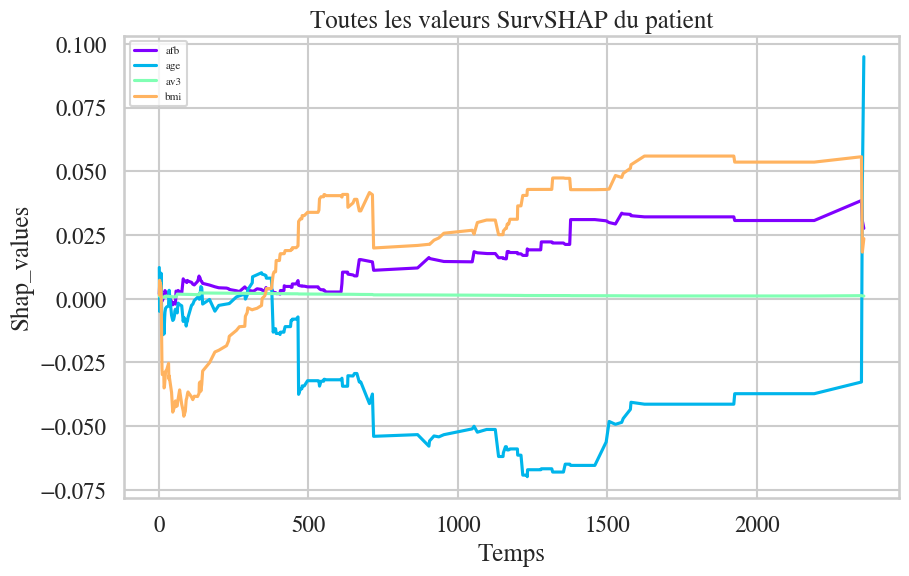

In [210]:
x_,y_ = fstp.Shapvalues(model= rsf, data=X_test.iloc[1, :], times=None)
fstp.STP_graph(x=x_, y=y_, columns=list(X.columns), selection=None)

In [211]:
# create explainer
explainer = SurvivalModelExplainer(model = rsf, data = X_train, y = y_train)

# compute SHAP values for a single instance
observation_A = X_test.iloc[[1]]
survshap_A = PredictSurvSHAP()

survshap_A.fit(explainer = explainer, new_observation = observation_A, timestamps=None) #rsf.estimators_[0].unique_times_

survshap_A.result 
survshap_A.plot()

# Graphiques Complexité

## 1/Complexité en points de temps

In [248]:
import importlib
importlib.reload(fstp)

<module 'fonctions_SurvTreeShap' from '/Users/gillesfevry/Surv-ML-1/fonctions_SurvTreeShap.py'>

In [258]:
def Temps_points_de_temps(rsf, X_test, y_train, eval_times):
    
    # time SuvrSHAP Kernel
    explainer = SurvivalModelExplainer(model = rsf, data = X_train, y = y_train)
    observation_A = X_test.iloc[[0]]
    survshap_A = PredictSurvSHAP()

    start=time.time()
    survshap_A.fit(explainer = explainer, new_observation = observation_A, timestamps=eval_times) 
    total_shap=time.time() - start

    # time SurvTreeSHAP
    STS=fstp.SurvTreeSHAPexplainer(rsf, X_test, times=eval_times)
    start=time.time()
    _=STS.computesurvshap(0)
    total_treeshap=time.time() - start

    return(total_treeshap,total_shap)

In [269]:
Temps_points_de_temps(rsf, X_test, y_train, np.linspace(0,rsf.estimators_[0].unique_times_[-1:], 5)[:,0])

100%|██████████| 5/5 [00:00<00:00, 399.65it/s]


(0.013559103012084961, 0.43694400787353516)

In [265]:
def Comparaison_points_de_temps(rsf, X_test, y_train, nb_temps=1):
    x=list(range(nb_temps))
    y=np.array([Temps_points_de_temps(rsf, X_test, y_train, np.linspace(0,rsf.estimators_[0].unique_times_[-1:], i+1)[:,0]) for i in x])
    y_tree=y[:,0]
    y_kernel=y[:,1]

    a, b = np.polyfit(x, y_kernel, 1)
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = a * x_fit + b
    plt.scatter(x, y_kernel, color='blue', label="Kernel")
    plt.plot(x_fit, y_fit, color='blue', label=f"y = {int(a*1000)/1000}x + {int(b*1000)/1000}")

    a, b = np.polyfit(x, y_tree, 1)
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = a * x_fit + b
    plt.scatter(x, y_tree, color='green', label="Tree")
    plt.plot(x_fit, y_fit, color='green', label=f"y = {int(a*1000)/1000}x + {int(b*1000)/1000}")

    plt.xlabel("Nombre de temps calculés ")
    plt.ylabel("Temps d'exécution")
    plt.legend()
    plt.title("Temps d'exécution des deux versions de shap selon le nombre de temps calculés pour une RSF à 4 variables.")
    plt.grid()
    plt.show()

100%|██████████| 50/50 [00:00<00:00, 458.10it/s]


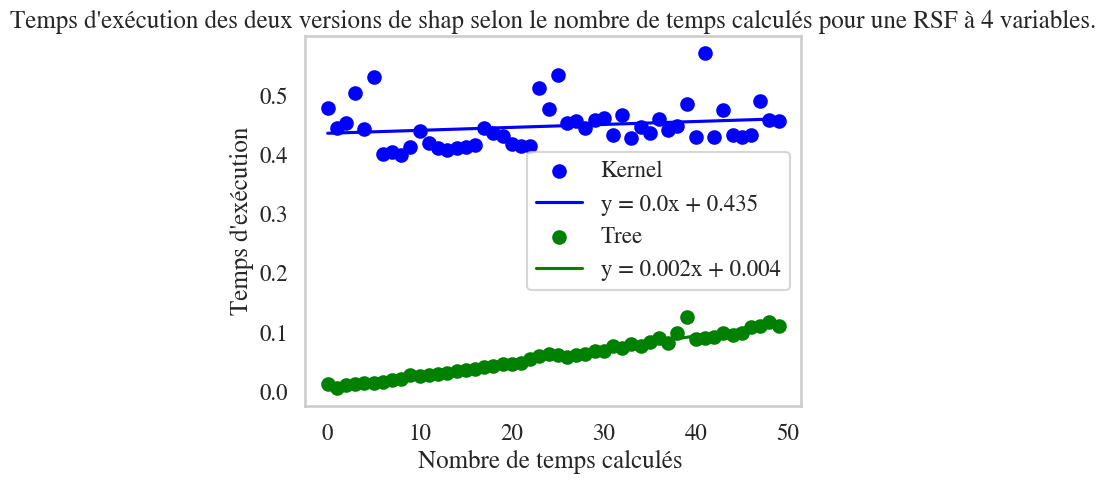

In [270]:
Comparaison_points_de_temps(rsf, X_test, y_train, nb_temps=50)

## 2/Complexité en nombre de variables

In [271]:
def graph_var(n):
    y_kernel=[]
    y_tree=[]
    t=[]
    for i in tqdm(range(n)):
        X, y = load_whas500()
        X = X.astype(float)
        X = X.iloc[:, :i+1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        rsf = RandomSurvivalForest(random_state=42, max_depth=4, max_leaf_nodes=16).fit(X_train, y_train)

       # time KerneleSHAP

        explainer = SurvivalModelExplainer(model = rsf, data = X_train, y = y_train)
        observation_A = X_test.iloc[[0]]
        survshap_A = PredictSurvSHAP()

        start=time.time()
        survshap_A.fit(explainer = explainer, new_observation = observation_A) 
        y_kernel.append(time.time() - start)

        # time SurvTreeSHAP
        STS=fstp.SurvTreeSHAPexplainer(rsf, X_test)
        start=time.time()
        _=STS.computesurvshap(0)
        y_tree.append(time.time()- start)
        
        t.append(i)

    log_y_kernel=np.log(np.array(y_kernel))
    a, b = np.polyfit(t, log_y_kernel, 1)
    x_fit = np.linspace(min(t), max(t), 100)
    y_fit = np.exp(b) * (np.exp(a)**x_fit)
    plt.scatter(t, y_kernel, color='blue', label="Kernel")
    plt.plot(x_fit, y_fit, color='blue', label=f"y = {int(np.exp(b)*1000)/1000} *({int(np.exp(a)*1000)/1000}**d)")

    a, b = np.polyfit(t, y_tree, 1)
    x_fit = np.linspace(min(t), max(t), 100)
    y_fit = a * x_fit + b
    plt.scatter(t, y_tree, color='green', label="Tree")
    plt.plot(x_fit, y_fit, color='green', label=f"y = {int(a*1000)/1000}d + {int(b*1000)/1000}")

    plt.xlabel("Nombre de variables dans l'arbre")
    plt.ylabel("Temps d'exécution en secondes")
    plt.legend()
    plt.title("Temps d'exécution de SuvrSHAP(t) selon le nombre de variables dans la RSF")
    plt.grid()
    plt.show()
        
    

100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


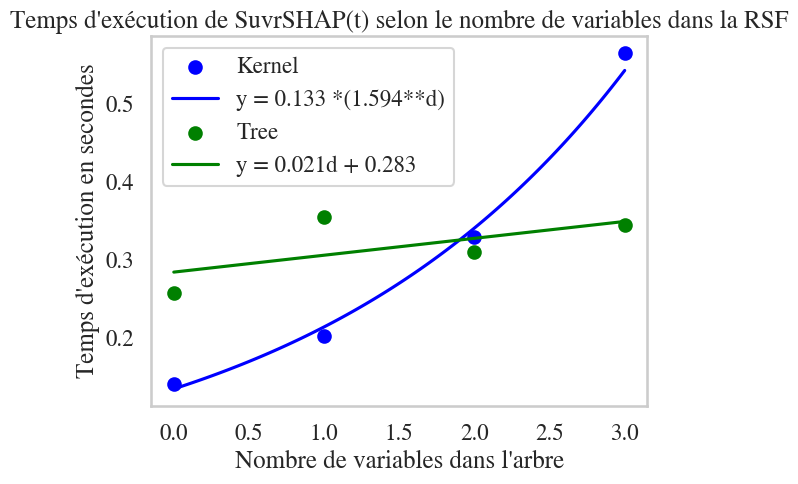

In [272]:
graph_var(4)

## 3/Effets indirects

In [301]:
data = pd.read_csv("METABRIC_RNA_Mutation.csv")
colones_00 = data.columns[520:]  # colones dont on veut faire passer 0 à "0", a partir de la colone "pik3ca_mut"
data[colones_00] = data[colones_00].astype(str) 
data[colones_00] = data[colones_00].applymap(lambda x: 0 if x == "0" else 1) # 0 indique qu'il n'y a pas de mutation, 1 indique qu'il y a une mutation
for col in data.select_dtypes(include=['object']).columns:
    data[col] = LabelEncoder().fit_transform(data[col])
y = data[["death_from_cancer", "overall_survival_months"]]
y['Died_of_Desease'] = (y['death_from_cancer'] == 0).astype(int) # on considère que censure = autres morts + sorties de l'étude
y=y.drop("death_from_cancer", axis=1)
X = data.drop(columns=["death_from_cancer", "overall_survival_months", "overall_survival"]) # on enlève les données de survie de X

/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_93393/303539646.py:1: DtypeWarning:

Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_93393/303539646.py:4: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_93393/303539646.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [302]:
def graph_var_indirect(n, X, y):
    y_tree=[]
    max_depth=[]
    creating_tree=[]
    nb_leaves=[]
    t=[]
    for i in range(n):
        X_ = X.iloc[:, :50+50*i]
        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42)
        start=time.time()
        rsf = RandomSurvivalForest(random_state=42).fit(X_train, y_train)
        creating_tree.append(time.time()-start)

        STS=fstp.SurvTreeSHAPexplainer(rsf, X_test)

        # time SurvTreeSHAP
        start=time.time()
        _=STS.computesurvshap(0)
        y_tree.append(time.time()- start)
        
        t.append(X_.shape[1])
        max_depth.append(np.average([i.tree_.max_depth for i in rsf.estimators_]))
        nb_leaves.append(np.average([i.tree_.n_leaves for i in rsf.estimators_]))

    a, b, c = np.polyfit(t, y_tree, 2)
    x_fit = np.linspace(min(t), max(t), 100)
    plt.scatter(t, y_tree, color='green', label="temps de calcul de SurvTreeSHAP")
    plt.plot(t,creating_tree, color='yellow', label = "temps de calcul pour entraîner la RSF")
    plt.plot(t,max_depth, color='red', label = "profondeur moyenne de la RSF")
    plt.plot(t,nb_leaves, color='blue', label = "nombre de feuille moyen de la RSF")

    plt.xlabel("Nombre de variables dans l'arbre")
    plt.ylabel("secondes ou unités")
    plt.legend()
    plt.grid()
    plt.show()

    return(y_tree, creating_tree, max_depth, nb_leaves)

100%|██████████| 1374/1374 [00:20<00:00, 66.77it/s]
/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_93393/2495443222.py:2: RankWarning:

Polyfit may be poorly conditioned



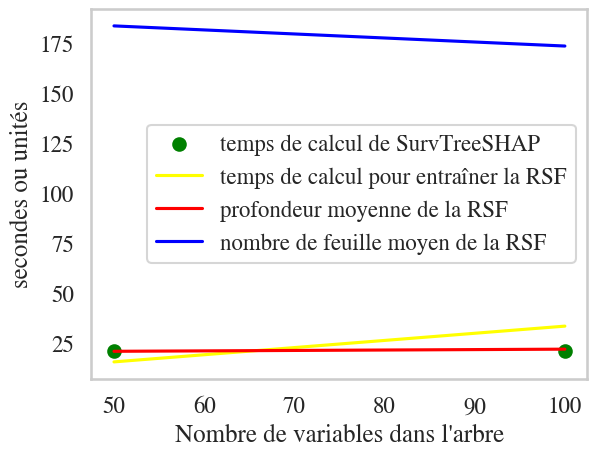

In [303]:
y_rsf=Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y)
a=graph_var_indirect(2, X, y_rsf)

# Scalabilité

In [313]:
X, y = load_whas500()
X = X.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rsf = RandomSurvivalForest(random_state=42).fit(X_train, y_train)

100%|██████████| 324/324 [00:01<00:00, 268.58it/s]


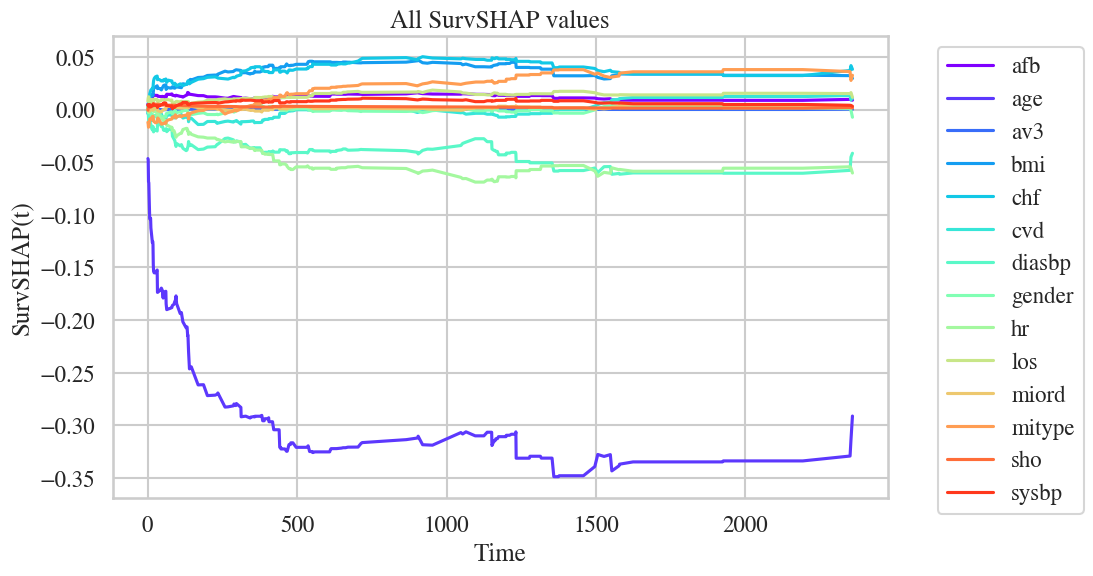

In [318]:
STS=fstp.SurvTreeSHAPexplainer(rsf, X_test)
STS.plotgraph(4)

100%|██████████| 324/324 [00:01<00:00, 316.68it/s]


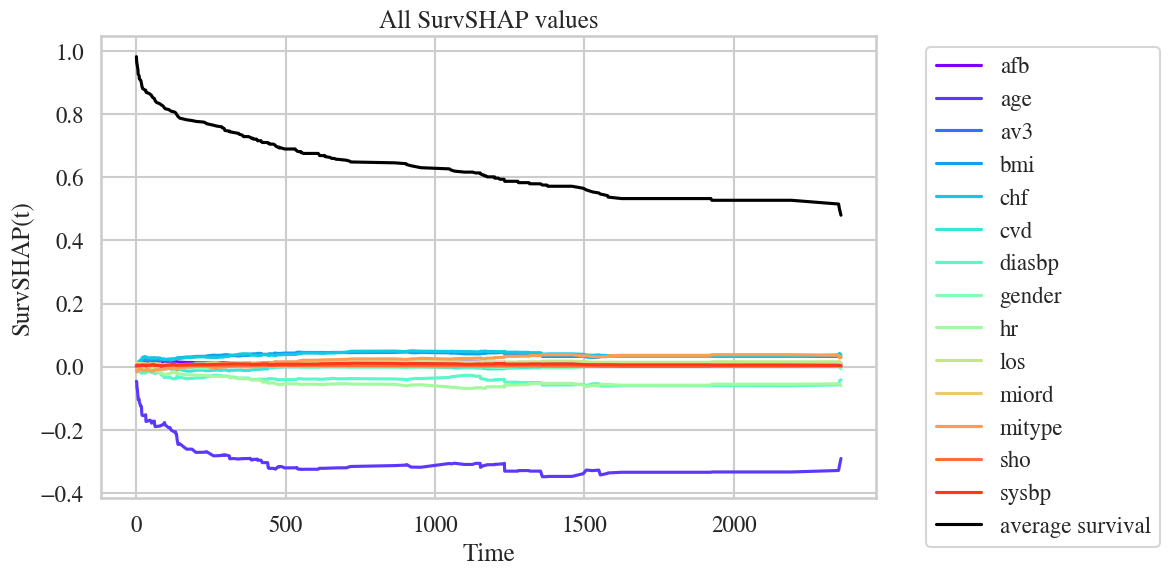

In [319]:
STS.plotgraph(4, plot_average_surv=True)

## Essais données simulées

In [320]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

n_samples= 2000 
n_features = 100
# Générer 500 patients avec 50 covariables
X, y = make_classification(n_samples=n_samples, n_features=n_features, random_state=42)

# Simuler des temps de survie et des événements censurés
np.random.seed(42)
survival_time = np.random.exponential(scale=365, size=n_samples)  # Temps aléatoires (jours)
event_observed = np.random.choice([1, 0], size=n_samples)  # Événements observés (1) ou censurés (0)

# Convertir en DataFrame
df = pd.DataFrame(X, columns=[f"covariate_{i}" for i in range(X.shape[1])])
df["time"] = survival_time
df["event"] = event_observed

print(df.head())

   covariate_0  covariate_1  covariate_2  covariate_3  covariate_4  \
0    -0.269741    -0.431751     0.908414    -0.564952    -0.240209   
1     1.367681    -0.732311    -2.466412     0.105341     0.125983   
2    -0.899725    -0.061788     0.831007     0.141649     0.266585   
3    -1.625421     0.496253    -0.169132    -0.136818     0.583187   
4    -0.288856    -1.435056    -0.869850     1.575428    -1.213128   

   covariate_5  covariate_6  covariate_7  covariate_8  covariate_9  ...  \
0     0.353679     1.015857    -1.478114     0.908445     0.415663  ...   
1    -0.495463    -0.471963    -0.245569    -0.329360     0.692020  ...   
2     0.117864     0.321279    -0.385240     0.813552    -0.882826  ...   
3    -1.211610    -0.220999     0.826985     1.244261     1.415743  ...   
4    -0.435024     0.920347     0.462395    -1.057771    -0.068979  ...   

   covariate_92  covariate_93  covariate_94  covariate_95  covariate_96  \
0      0.329959     -0.203883      0.008538     -0.18

In [321]:
from sksurv.util import Surv

# Convertir la colonne (time, event) au bon format
y = Surv.from_arrays(event=df["event"], time=df["time"].values)

# Séparer les covariables (X)
X = df.drop(columns=["time", "event"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [322]:
rsf = RandomSurvivalForest(n_estimators=100, max_depth=3, random_state=42)
rsf.fit(X, y)

RandomSurvivalForest(max_depth=3, random_state=42)

100%|██████████| 2000/2000 [00:01<00:00, 1093.10it/s]


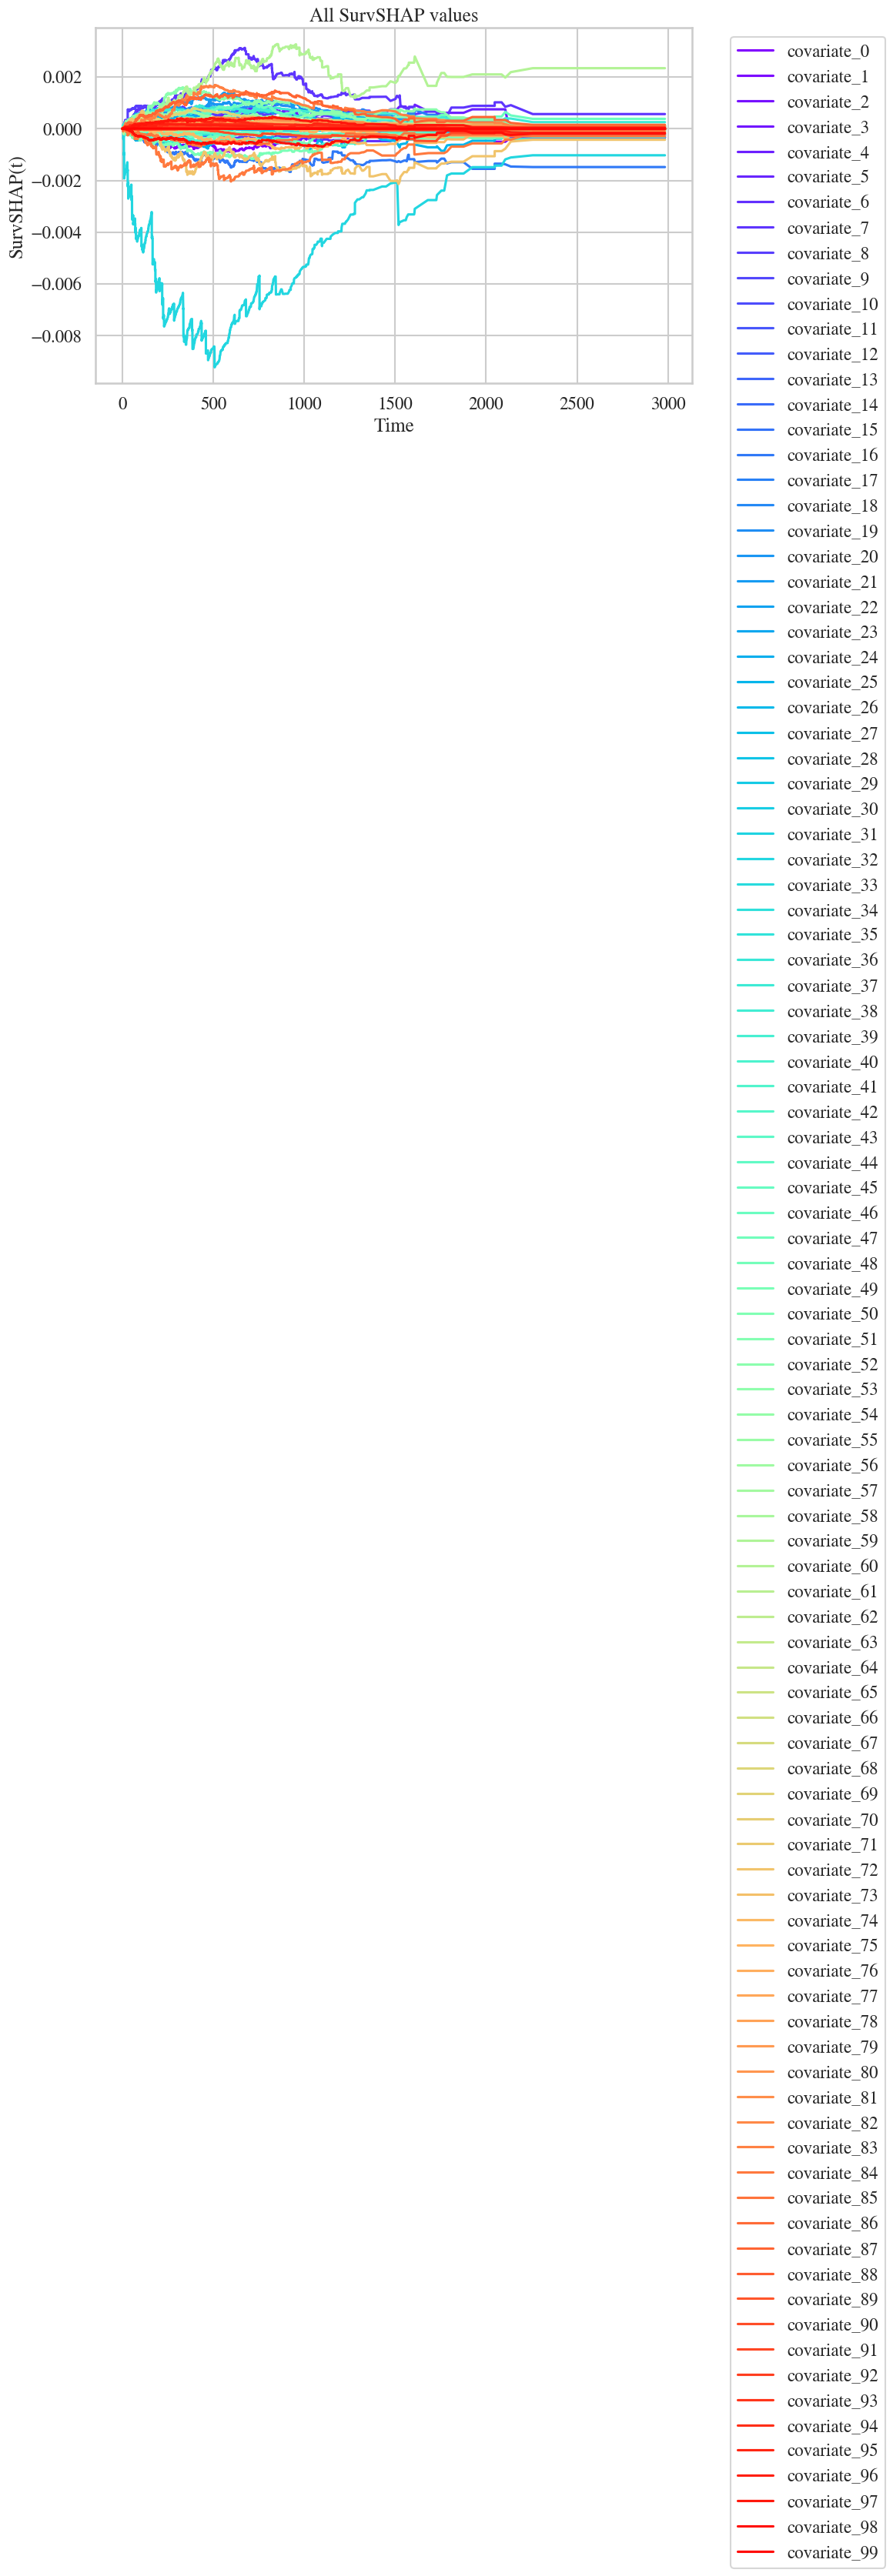

In [325]:
STS=fstp.SurvTreeSHAPexplainer(rsf, X_test)
STS.plotgraph(1)